## What's Cooking?

**Hsing-Yi Wang**

### Import Modules

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Import & Prepare Data

In [15]:
train_df = pd.read_json('/Users/eve7947/Downloads/train.json')
test_df = pd.read_json('/Users/eve7947/Downloads/test.json')

train_df['sep_ing'] = train_df['ingredients'].apply(','.join)
test_df['sep_ing'] = test_df['ingredients'].apply(','.join)

**Create binary variable for ingredients**

In [16]:
ingreList = []
for index, row in train_df.iterrows():
    ingre = row['ingredients']
    
    for i in ingre:
        if i not in ingreList:
            ingreList.append(i)
def binary(ingre_list):
    binaryList = []
    
    for item in ingreList:
        if item in ingre_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList
train_df['bin ingredients']=train_df['ingredients'].apply(lambda x: binary(x))

In [17]:
train_df.head()

,cuisine,id,ingredients,sep_ing,bin ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...","romaine lettuce,black olives,grape tomatoes,ga...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...","plain flour,ground pepper,salt,tomatoes,ground...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...","eggs,pepper,salt,mayonaise,cooking oil,green c...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
3,indian,22213,"[water, vegetable oil, wheat, salt]","water,vegetable oil,wheat,salt","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...","black pepper,shallots,cornflour,cayenne pepper...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


### Explore Data

**Distrubition of cusines**

Text(0.5,1,'Cuisine Distribution')

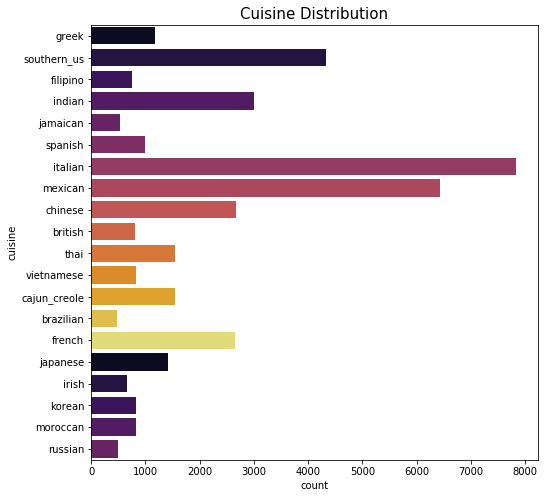

In [18]:
sns.countplot(y='cuisine', data=train_df,palette=sns.color_palette('inferno',15))
plt.gcf().set_size_inches(8,8)
plt.title('Cuisine Distribution',size=15)

**Find most common ingredients**

Text(0.5,1,'Top 15 Ingredients')

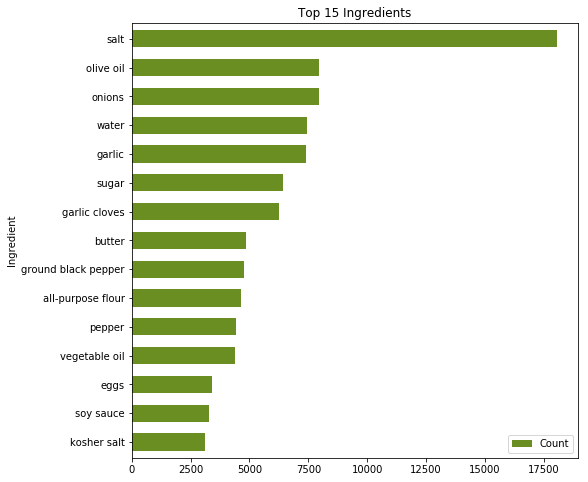

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(tokenizer=lambda x: [i.strip() for i in x.split(',')], lowercase=False)
counts = vec.fit_transform(train_df['sep_ing']) 
count=dict(zip(vec.get_feature_names(), counts.sum(axis=0).tolist()[0]))
count=pd.DataFrame(list(count.items()),columns=['Ingredient','Count'])
count.set_index('Ingredient').sort_values('Count',ascending=False)[:15].plot.barh(width=0.6, color='olivedrab')
plt.gcf().set_size_inches(8,8)
plt.gca().invert_yaxis()
plt.title('Top 15 Ingredients')

In [20]:
import nltk
from collections import Counter

In [21]:
train_df['for ngrams']=train_df['sep_ing'].str.replace(',',' ')

In [22]:
train_df.head()

,cuisine,id,ingredients,sep_ing,bin ingredients,for ngrams
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...","romaine lettuce,black olives,grape tomatoes,ga...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...",romaine lettuce black olives grape tomatoes ga...
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...","plain flour,ground pepper,salt,tomatoes,ground...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...",plain flour ground pepper salt tomatoes ground...
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...","eggs,pepper,salt,mayonaise,cooking oil,green c...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",eggs pepper salt mayonaise cooking oil green c...
3,indian,22213,"[water, vegetable oil, wheat, salt]","water,vegetable oil,wheat,salt","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",water vegetable oil wheat salt
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...","black pepper,shallots,cornflour,cayenne pepper...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",black pepper shallots cornflour cayenne pepper...


In [23]:
import networkx as nx
def generate_ngrams(text, n):
    words = text.split(' ')
    iterations = len(words) - n + 1
    for i in range(iterations):
        yield words[i:i + n]
        
def net_diagram(*cuisines):
    ngrams = {}
    for title in train_df[train_df.cuisine==cuisines[0]]['for ngrams']:
        for ngram in generate_ngrams(title, 2):
            ngram = ','.join(ngram)
            if ngram in ngrams:
                ngrams[ngram] += 1
            else:
                ngrams[ngram] = 1

    ngrams_mws_df = pd.DataFrame.from_dict(ngrams, orient='index')
    ngrams_mws_df.columns = ['count']
    ngrams_mws_df['cusine'] = cuisines[0]
    ngrams_mws_df.reset_index(level=0, inplace=True)

    ngrams = {}
    for title in train_df[train_df.cuisine==cuisines[1]]['for ngrams']:
            for ngram in generate_ngrams(title, 2):
                ngram = ','.join(ngram)
                if ngram in ngrams:
                    ngrams[ngram] += 1
                else:
                    ngrams[ngram] = 1

    ngrams_mws_df1 = pd.DataFrame.from_dict(ngrams, orient='index')
    ngrams_mws_df1.columns = ['count']
    ngrams_mws_df1['cusine'] = cuisines[1]
    ngrams_mws_df1.reset_index(level=0, inplace=True)
    cuisine1=ngrams_mws_df.sort_values('count',ascending=False)[:25]
    cuisine2=ngrams_mws_df1.sort_values('count',ascending=False)[:25]
    df_final=pd.concat([cuisine1,cuisine2])
    g = nx.from_pandas_edgelist(df_final,source='cusine',target='index')
    cmap = plt.cm.RdYlGn
    colors = [n for n in range(len(g.nodes()))]
    k = 0.35
    pos=nx.spring_layout(g, k=k)
    nx.draw_networkx(g,pos, node_size=df_final['count'].values*8, cmap = cmap, node_color=colors, edge_color='grey', font_size=15, width=3)
    plt.title("Top 25 Bigrams for %s and %s" %(cuisines[0],cuisines[1]), fontsize=30)
    plt.gcf().set_size_inches(20,20)
    plt.show()
    plt.savefig('network.png')

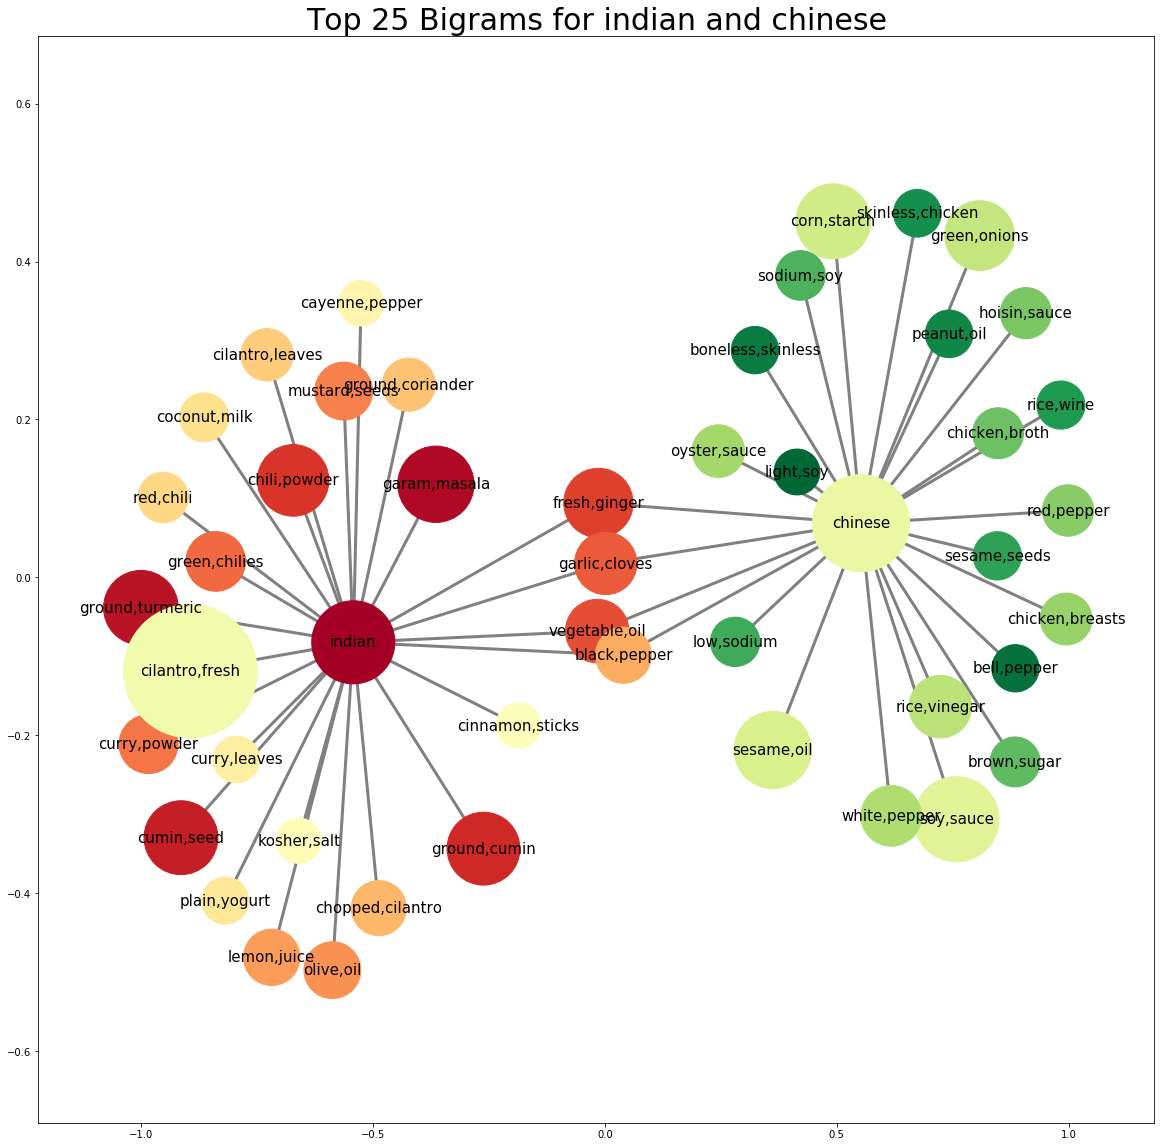

<Figure size 432x288 with 0 Axes>

In [30]:
net_diagram('indian','chinese')

### Modeling - Logistic Regression

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(binary=True).fit(train_df['sep_ing'].values)
X_train_vectorized = vect.transform(train_df['sep_ing'].values)
X_train_vectorized = X_train_vectorized.astype('float')
Result_transformed = vect.transform(test_df['sep_ing'].values)
Result_transformed = Result_transformed.astype('float')

In [26]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_transformed = encoder.fit_transform(train_df.cuisine)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_vectorized, y_transformed , random_state = 0)

from sklearn.linear_model import LogisticRegression

clf1 = LogisticRegression(C=10,dual=False)
clf1.fit(X_train , y_train)
clf1.score(X_test, y_test)

/Users/eve7947/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/eve7947/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.7942477876106194

### Ensemble Model

In [12]:
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
vclf=VotingClassifier(estimators=[('clf1',LogisticRegression(C=10,dual=False)),('clf2',SVC(C=100,gamma=1,kernel='rbf',probability=True))],voting='soft',weights=[1,2])
vclf.fit(X_train , y_train)
vclf.score(X_test, y_test)

/Users/eve7947/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/eve7947/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.8148632341110217

In [13]:
y_predicted = vclf.predict(Result_transformed)
y_predicted_final = encoder.inverse_transform(y_predicted)
predictions = pd.DataFrame({'cuisine' : y_predicted_final , 'id' : test_df.id })
predictions = predictions[[ 'id' , 'cuisine']]
predictions.to_csv('submit.csv', index = False)